In [2]:
from pathlib import Path

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer

In [3]:
BASE_PATH = Path('/home/urbanaq/data')

REGIONS = {
    "IBERIA": {"min_lat": 35.7,
               "min_lon": -9.9,
               "max_lat": 44.1,
               "max_lon": 4.5}
}

# Plot ERA5 variables

In [5]:
xds = xr.open_dataset(BASE_PATH / 'era5' / 'era5_IBERIA.nc')
xds

<xarray.Dataset> Size: 415MB
Dimensions:     (time: 17520, latitude: 34, longitude: 58)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 140kB 2022-01-01 ... 2023-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 272B 44.0 43.75 43.5 ... 36.25 36.0 35.75
  * longitude   (longitude) float64 464B -9.75 -9.5 -9.25 -9.0 ... 4.0 4.25 4.5
    valid_time  (time) datetime64[ns] 140kB ...
Data variables:
    blh         (time, latitude, longitude) float32 138MB ...
    iews        (time, latitude, longitude) float32 138MB ...
    inss        (time, latitude, longitude) float32 138MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-06-08T18:06 GRIB to CDM+CF via cfgrib-0.9.1...

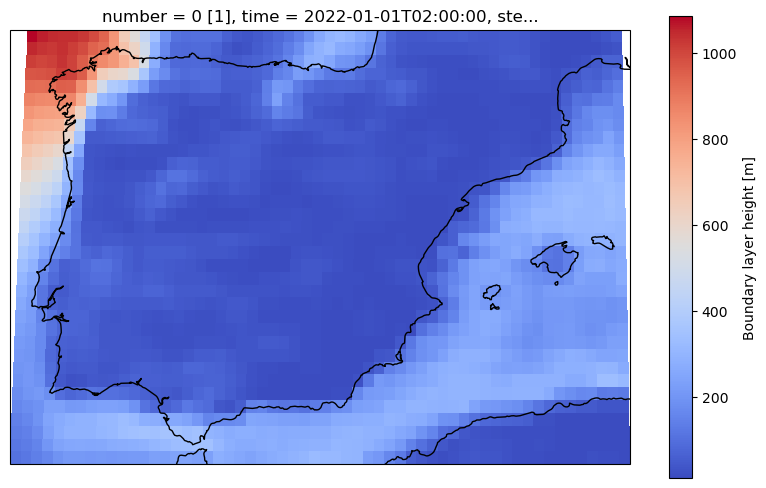

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
xds.blh[2].plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6})
plt.show()

In [7]:
del xds

# Plot ERA5 Land variables

In [8]:
xds = xr.open_dataset(BASE_PATH / 'era5_land' / 'era5_land_IBERIA.nc')
xds

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 754, step: 24, latitude: 84, longitude: 144)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 6kB 2021-12-31 2022-01-01 ... 2023-12-31
  * step        (step) timedelta64[ns] 192B 01:00:00 ... 1 days 00:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 672B 44.0 43.9 43.8 43.7 ... 35.9 35.8 35.7
  * longitude   (longitude) float64 1kB -9.9 -9.8 -9.7 -9.6 ... 4.1 4.2 4.3 4.4
    valid_time  (time, step) datetime64[ns] 145kB ...
Data variables:
    u10         (time, step, latitude, longitude) float32 876MB ...
    v10         (time, step, latitude, longitude) float32 876MB ...
    t2m         (time, step, latitude, longitude) float32 876MB ...
    ssr         (time, step, latitude, longitude) float32 876MB ...
    tp          (time, step, latitude, longitude) float32 876MB ...
    d2m         (time, step, latitude, longitude) float32 876MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-06-10T13:11 GRIB to CDM+CF via cfgrib-0.9.1...

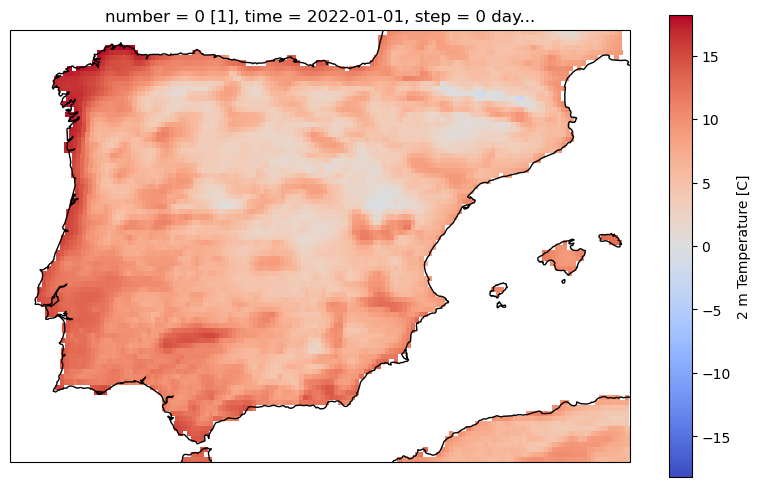

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
data = xds.sel(time="2022-01-01", step="01:00:00").t2m - 273.15
data.plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6, "label": "2 m Temperature [C]"})
plt.show()

In [10]:
del xds

# Plot CAMS data

In [11]:
xds = xr.open_dataset(BASE_PATH / 'cams' / 'no2' / 'no2_IBERIA.nc')
xds

<xarray.Dataset> Size: 848MB
Dimensions:  (time: 17520, lat: 84, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 140kB 2022-01-01 ... 2023-12-31T23:00:00
  * lon      (lon) float64 1kB -9.85 -9.75 -9.65 -9.55 ... 4.15 4.25 4.35 4.45
  * lat      (lat) float64 672B 35.75 35.85 35.95 36.05 ... 43.85 43.95 44.05
Data variables:
    no2      (time, lat, lon) float32 848MB ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

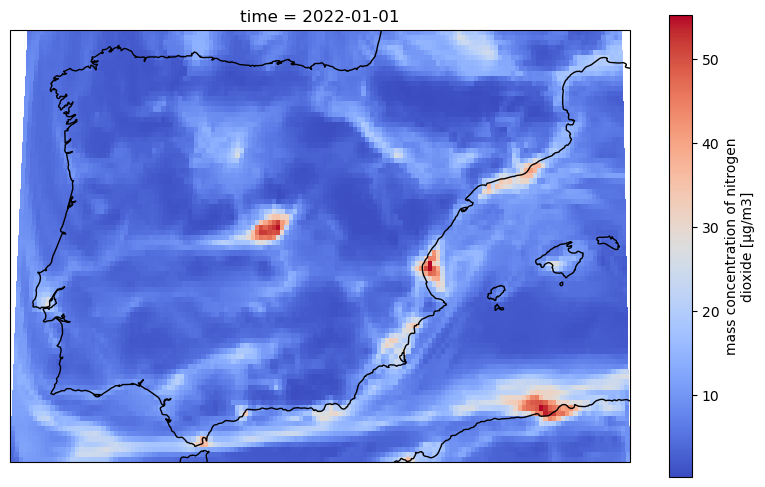

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
data = xds.sel(time="2022-01-01T00:00:00").no2.plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6})
plt.show()

In [13]:
del xds

# EEA Stations

In [14]:
df = pd.read_csv(BASE_PATH / 'eea' / 'stations.csv', usecols=['Country', "Longitude", "Latitude"])
bbox = REGIONS["IBERIA"]
df = df[df.Longitude.between(bbox["min_lon"], bbox["max_lon"]) & df.Latitude.between(bbox["min_lat"], bbox["max_lat"])]


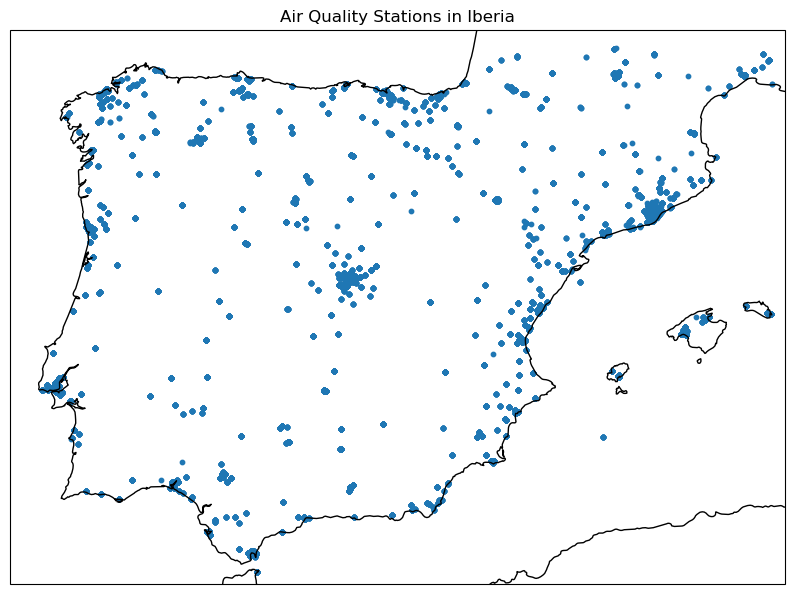

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(df.Longitude, df.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title("Air Quality Stations in Iberia")
plt.show()

# Plot CORINE Land Cover

In [48]:
input_f = BASE_PATH / 'corine_land_cover' / 'u2018_clc2018_v2020_20u1_raster100m' / 'DATA' / 'U2018_CLC2018_V2020_20u1.tif'
output_f = BASE_PATH / 'corine_land_cover' / 'raster100m_4326' / 'U2018_CLC2018_V2020_20u1_4326.tif'

if not output_f.parent.exists():
    output_f.parent.mkdir(parents=True)

dst_crs = 'EPSG:4326'

with rasterio.open(str(input_f)) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(output_f, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

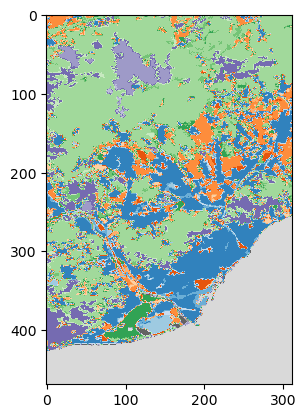

In [50]:
land_cover_4326 = BASE_PATH / 'corine_land_cover' / 'raster100m_4326' / 'U2018_CLC2018_V2020_20u1_4326.tif'

bbox = REGIONS["IBERIA"]
# Barcelona
bbox = {
    "min_lat": 41.2,
    "min_lon": 1.9,
    "max_lat": 41.8,
    "max_lon": 2.3
}

with rasterio.open(str(land_cover_4326)) as src:
    # use bbox to read only the region of interest
    window = src.window(bbox["min_lon"], bbox["min_lat"], bbox["max_lon"], bbox["max_lat"])
    data = src.read(1, window=window)

# 4: Road and rail networks and associated land
# data = np.where(data == 4, 1, 0)


plt.imshow(data, cmap='tab20c')


# GHS

In [5]:
def get_barcelona(input_f):
    # Barcelona
    bbox = {
        "min_lat": 41.2,
        "min_lon": 1.9,
        "max_lat": 41.8,
        "max_lon": 2.3
    }

    with rasterio.open(str(input_f)) as src:
        # use bbox to read only the region of interest

        transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
        min_lon, min_lat = transformer.transform(bbox["min_lon"], bbox["min_lat"])
        max_lon, max_lat = transformer.transform(bbox["max_lon"], bbox["max_lat"])

        window = src.window(min_lon, min_lat, max_lon, max_lat)
        data = src.read(1, window=window)
        

    return data, src.transform, src.crs

## GHS LAND

Resolution of 100m - World Mollweide (EPSG:54009)

range [0:10 000]

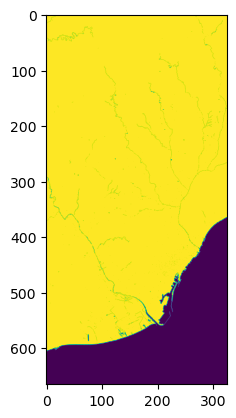

In [7]:
input_f = BASE_PATH / 'ghs_land' / 'GHS_LAND_E2018_GLOBE_R2022A_54009_100_V1_0.tif'

data, transform, crs = get_barcelona(input_f)
plt.imshow(data)

In [28]:
del data, transform, crs

## GHS-BUILT-H

GHS Average of the Gross Building Height (AGBH). Values are expressed as decimals 

(Float) reporting about the amount of built cubic meters per surface unit in the cell.
NoData [0]

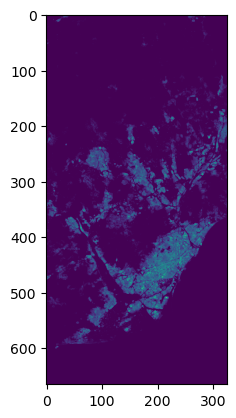

In [8]:
input_f = BASE_PATH / 'ghs_built_h' / 'GHS_BUILT_H_AGBH_E2018_GLOBE_R2023A_54009_100_V1_0.tif'

data, transform, crs = get_barcelona(input_f)
plt.imshow(data)

In [ ]:
del data, transform, crs

## GHS-POP

Values are expressed as decimals (Float) and represent the absolute number of inhabitants of the cell.

NoData [-200]

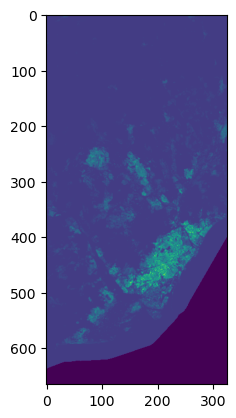

In [9]:
input_f = BASE_PATH / 'ghs_pop' / 'GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif'

data, transform, crs = get_barcelona(input_f)
plt.imshow(data)

In [ ]:
del data, transform, crs

# EPRTR

In [43]:
input_f = BASE_PATH / 'eprtr' / 'points.csv'

eprtr = pd.read_csv(input_f)
eprtr


,sector,category,lon,lat
0,1 Energy sector,1.(a) Mineral oil and gas refineries,22.878000,40.679500
1,1 Energy sector,1.(a) Mineral oil and gas refineries,23.602761,38.032359
2,1 Energy sector,1.(a) Mineral oil and gas refineries,23.602761,38.032359
3,1 Energy sector,1.(a) Mineral oil and gas refineries,23.510833,38.042222
4,1 Energy sector,1.(a) Mineral oil and gas refineries,23.510833,38.042222
...,...,...,...,...
302175,activity_27,NaN,5.166656,51.082680
302176,activity_27,NaN,14.090125,45.199270
302177,activity_27,NaN,13.794890,56.161281
302178,activity_27,NaN,13.876833,46.620530


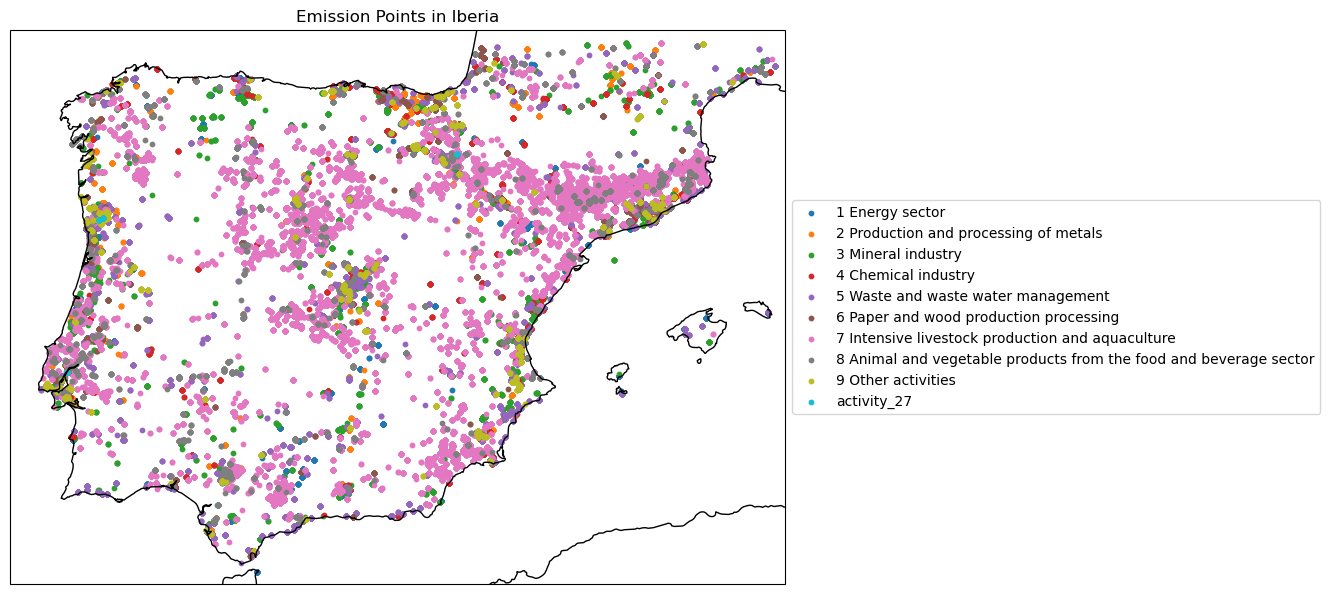

In [52]:
bbox = REGIONS["IBERIA"]

# Emission points in Iberia
eprtr = eprtr[eprtr.lon.between(bbox["min_lon"], bbox["max_lon"]) & eprtr.lat.between(bbox["min_lat"], bbox["max_lat"])]

# Plot the emission points. Color by sector

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
for sector, group in eprtr.groupby("sector"):
    ax.scatter(group.lon, group.lat, transform=ccrs.PlateCarree(), s=10, label=sector)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Emission Points in Iberia")
plt.show()

# Topography

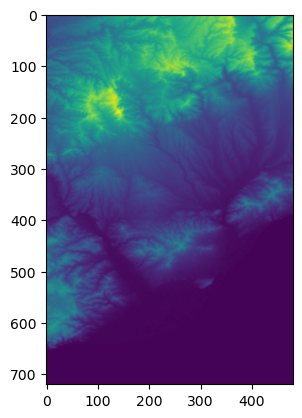

In [6]:
input_f = BASE_PATH / 'nasa_topo' / 'output.tif'

data, transform, crs = get_barcelona(input_f)
plt.imshow(data)